# Моделирование оттока клиентов банка

На основе исторических данных о поведении клиентов банка нужно построить модель машинного обучения для предсказания ухода клиента. Задача бинарной классификации.

Нужно провести подготовку данных, преобразовать категориальные переменные в количественные методом OHE, отмасштабировать количественные признаки, попробовать 3 стратегии борьбы с дисбалансом классов: взвешивание классов, уменьшение и увеличение выборки. Далее нужно протестировать разные модели (DecisionTreeClassifier, RandomForestClassifier, LogisticRegression), найти оптимальные гиперпараметры с помощью GridSearchCV. В финале проверить лучшую модель на тестовой выборке и на адекватность.

Нужно построить модель с предельно большим значением *F1*-меры (>=0.59), дополнительно измерять *AUC-ROC*.

### План работы
1. [Подготовка данных.](#1.-Подготовка-данных.)
2. [Исследование задачи.](#2.-Исследование-задачи.)
3. [Борьба с дисбалансом.](#3.-Борьба-с-дисбалансом.)
4. [Тестирование модели.](#4.-Тестирование-модели.)
5. [Проверка модели на адекватность.](#5.-Проверка-модели-на-адекватность.)
6. [Общий вывод.](#6.-Общий-вывод.)

### Описание данных
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Характеристики клиентов банка: личная информация, количество неджижимости, продуктов банка, баланс на счете, активность. 
Целевой признак: факт ухода клиента.

---

# 1. Подготовка данных.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.model_selection import PredefinedSplit

#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('datasets/Churn.csv', index_col=0)
display(data.head(10))
data.info()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Проверим данные на наличие ошибок и пропусков:

In [3]:
data['HasCrCard'].unique()
data['IsActiveMember'].unique()
data['Exited'].unique()

array([1, 0])

In [4]:
data[data['Tenure'].isna()]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0


In [5]:
data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

Возможно, пропущенные значения в этом столбце означают отсутсвие недвижимости, заменим пропуски на нули:

In [6]:
data['Tenure'] = data['Tenure'].fillna(0)

Признаки `CustomerId` и `Surname` нам при обучении модели не пригодятся.

In [7]:
data = data.drop(['CustomerId', 'Surname'], axis=1)


Преобразуем категориальные данные в количественные методом OHE, так как она подходит для всех моделей, которые мы будем использовать. Чтоб не попасть в дамми-ловушку - используем параметр drop_first=True, чтобы убрать избыточные признаки.

In [8]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
2,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
3,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
4,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
5,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разобъем данные на на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. 

In [9]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']
features_all, features_test, target_all, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(features_all, target_all, test_size=0.25, random_state=12345, stratify=target_all)

print(features_all.shape)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(data.shape)

print(Counter(target_all))
print(Counter(target_train))
print(Counter(target_valid))
print(Counter(target_test))
print(Counter(target))

(8000, 11)
(6000, 11)
(2000, 11)
(2000, 11)
(10000, 11)
Counter({0: 6370, 1: 1630})
Counter({0: 4777, 1: 1223})
Counter({0: 1593, 1: 407})
Counter({0: 1593, 1: 407})
Counter({0: 7963, 1: 2037})


Масштабируем количественные признаки:

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [11]:
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Вывод
Данные были проверены на ошибки и пропуски. Найденные пропуски в столбце `Tenure` были заменены на нули. Столбцы, которые не влияют на целевой признак (фамилия или идентификационный номер) были удалены из датасета. Категориальные данные были переведены в количественные методом OHE, изначально количественные данные были масштабированны. Подготовленные данные были разбиты на 3 выборки: учебную, валидационную и тестовую.


# 2. Исследование задачи.

Посмотрим на значение F1 меры для модели логистической регрессии:

In [12]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1_valid = f1_score(target_valid, predicted_valid)
display(f1_valid)


0.3214953271028037

Значение очень низкое, посмотрим какое соотношение положительных и отрицательных значений в целевом признаке:

0    0.7963
1    0.2037
Name: Exited, dtype: float64

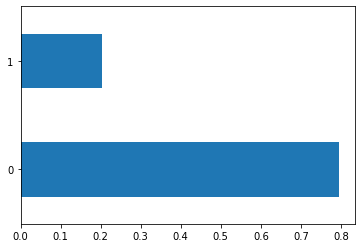

In [13]:
disbalance = data_ohe['Exited'].value_counts(normalize=True)
disbalance.plot(kind='barh')
disbalance

Класс клиентов, покинувших банк, почти в 4 раза меньше оставшихся.

### Вывод
Значения целевого призника не сбалансированы, вследствие чего значение F1 меры очень низкое.

# 3. Борьба с дисбалансом.

Взвешивание классов

In [14]:
params_decisionTree = {'max_depth': list(range(1, 6)),
                      'min_samples_split': list(range(2,6)),
                      'min_samples_leaf': list(range(1,6))
                      }
params_randomForest = {'max_depth': list(range(1, 6)),
                      'min_samples_split': list(range(2,6)),
                      'min_samples_leaf': list(range(1,6)),
                      'n_estimators': list(range(1,11)),
                      'criterion': ['gini', 'entropy']}

params_logicRegression = {'solver': ['lbfgs', 'liblinear'],
                      'C': np.logspace(-1,1, num=11)
                      }

In [15]:
train_ind = []
val_ind = []

for i in range(len(features_train)-1):
    train_ind.append(-1)
    
for i in range(len(features_valid)-1):
    val_ind.append(0)

ps = PredefinedSplit(test_fold=np.concatenate((train_ind,val_ind)))

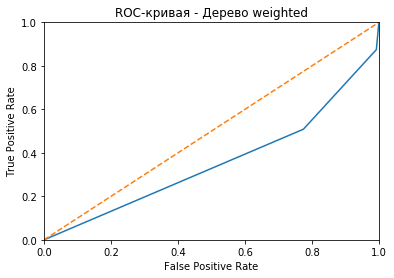

In [16]:
grid = GridSearchCV(
        estimator=DecisionTreeClassifier(class_weight='balanced', random_state=12345),
        param_grid=params_decisionTree,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all, target_all)

results = grid.cv_results_

data = pd.DataFrame([], columns = ['f1', 'roc-auc', 'best_parameters'])
data.loc['Дерево weighted'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Дерево weighted')

plt.show()

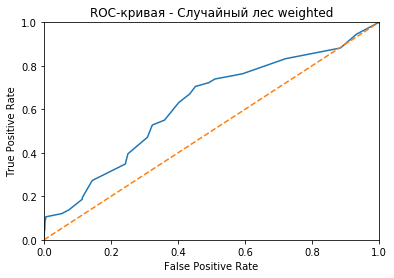

In [17]:
grid = GridSearchCV(
        estimator=RandomForestClassifier(class_weight='balanced', random_state=12345),
        param_grid=params_randomForest,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all, target_all)

results = grid.cv_results_

data.loc['Случайный лес weighted'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Случайный лес weighted')

plt.show()

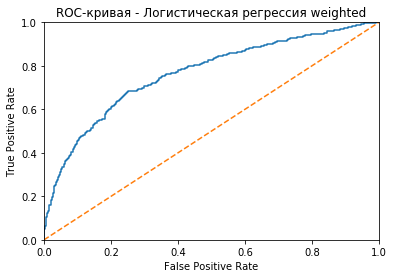

In [18]:
grid = GridSearchCV(
        estimator=LogisticRegression(random_state=12345, penalty='l2', class_weight='balanced'),
        param_grid=params_logicRegression,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all, target_all)

results = grid.cv_results_

data.loc['Логистическая регрессия weighted'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Логистическая регрессия weighted')

plt.show()

Увеличение выборки

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

train_ind = []
val_ind = []
print()
for i in range(len(features_upsampled)-1):
    train_ind.append(-1)
    
for i in range(len(features_valid)-1):
    val_ind.append(0)

ps = PredefinedSplit(test_fold=np.concatenate((train_ind,val_ind)))

In [20]:
features_all_up = pd.concat([features_upsampled] + [features_valid])
target_all_up = pd.concat([target_upsampled] + [target_valid])

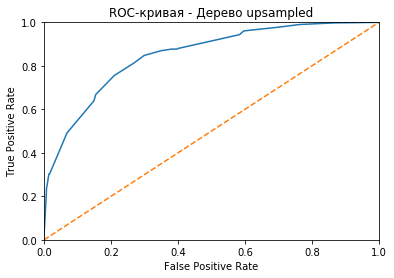

In [21]:
grid = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=12345),
        param_grid=params_decisionTree,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_up, target_all_up)

results = grid.cv_results_

data.loc['Дерево upsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Дерево upsampled')

plt.show()

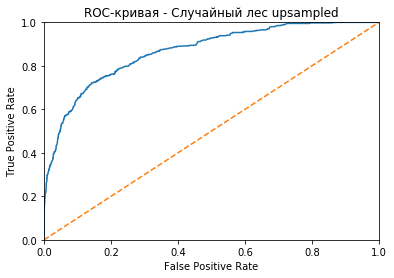

In [22]:
grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=12345),
        param_grid=params_randomForest,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_up, target_all_up)

results = grid.cv_results_

data.loc['Случайный лес upsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Случайный лес upsampled')

plt.show()

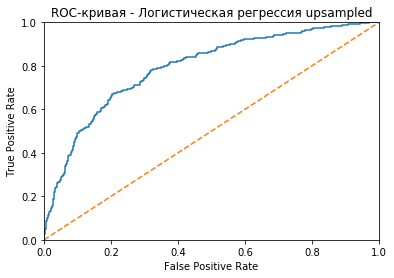

In [23]:
grid = GridSearchCV(
        estimator=LogisticRegression(random_state=12345, penalty='l2'),
        param_grid=params_logicRegression,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_up, target_all_up)

results = grid.cv_results_

data.loc['Логистическая регрессия upsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Логистическая регрессия upsampled')

plt.show()

Уменьшение выборки

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [25]:
train_ind = []
val_ind = []
print()
for i in range(len(features_downsampled)-1):
    train_ind.append(-1)
    
for i in range(len(features_valid)-1):
    val_ind.append(0)

ps = PredefinedSplit(test_fold=np.concatenate((train_ind,val_ind)))

In [26]:
features_all_down = pd.concat([features_downsampled] + [features_valid])
target_all_down = pd.concat([target_downsampled] + [target_valid])

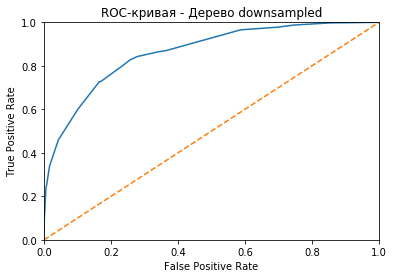

In [27]:
grid = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=12345),
        param_grid=params_decisionTree,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_down, target_all_down)

results = grid.cv_results_

data.loc['Дерево downsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Дерево downsampled')

plt.show()

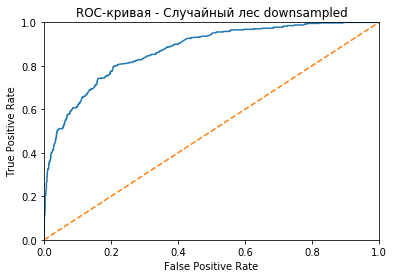

In [28]:
grid = GridSearchCV(
        estimator=RandomForestClassifier(random_state=12345),
        param_grid=params_randomForest,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_down, target_all_down)

results = grid.cv_results_

data.loc['Случайный лес downsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]

probabilities_one_valid = grid.predict_proba(features_valid)[:,1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Случайный лес downsampled')

plt.show()

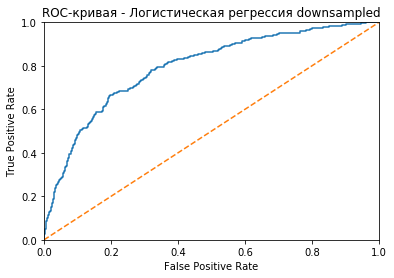

In [29]:
grid = GridSearchCV(
        estimator=LogisticRegression(random_state=12345, penalty='l2'),
        param_grid=params_logicRegression,
        scoring=['f1', 'roc_auc'],
        refit='f1',
        cv=ps)

grid.fit(features_all_down, target_all_down)

results = grid.cv_results_

data.loc['Логистическая регрессия downsampled'] = [grid.best_score_, results['mean_test_roc_auc'][grid.best_index_], grid.best_params_]


probabilities_one_valid = grid.predict_proba(features_valid)[:,1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - Логистическая регрессия downsampled')

plt.show()

Посмотрим, какая модель показала наивысшие значения F1 меры и AUC-ROC:

In [30]:
data.sort_values(by='f1', ascending=False)

,f1,roc-auc,best_parameters
Случайный лес downsampled,0.614300,0.861490,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
Случайный лес upsampled,0.606541,0.863416,"{'criterion': 'entropy', 'max_depth': 5, 'min_..."
Случайный лес weighted,0.593617,0.842585,"{'criterion': 'gini', 'max_depth': 5, 'min_sam..."
Дерево upsampled,0.561102,0.842954,"{'max_depth': 5, 'min_samples_leaf': 3, 'min_s..."
Дерево downsampled,0.553438,0.846366,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
Дерево weighted,0.538797,0.839477,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
Логистическая регрессия downsampled,0.509091,0.791637,"{'C': 0.1, 'solver': 'liblinear'}"
Логистическая регрессия upsampled,0.506438,0.791519,"{'C': 0.1, 'solver': 'liblinear'}"
Логистическая регрессия weighted,0.454626,0.730659,"{'C': 0.1, 'solver': 'liblinear'}"


### Вывод
Были рассмотрены 3 способа борьбы с дисбалансом классов: взвешивание классов, увеличение и уменьшение выборки. Наилучшие значения F1 меры показала модель случайного леса с уменьшенной выборкой.

In [31]:
best_model = data.loc['Случайный лес downsampled', 'best_parameters']

# 4. Тестирование модели.

F1:  0.6013071895424837
AUC-ROC 0.8514670294331312


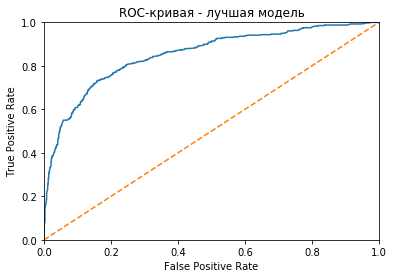

In [32]:
model = RandomForestClassifier(criterion=best_model['criterion'], max_depth=best_model['max_depth'],
                       min_samples_leaf=best_model['min_samples_leaf'],
                       min_samples_split=best_model['min_samples_split'],
                       n_estimators=best_model['n_estimators'],
                       random_state=12345)

model.fit(features_all_down, target_all_down) 
predicted_test = model.predict(features_test) 
f1_test = f1_score(target_test, predicted_test)
print('F1: ',f1_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC', auc_roc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая - лучшая модель')

plt.show()

# 5. Проверка модели на адекватность.

Проверим модель на адекватность с помощью DummyClassifier:

In [33]:
model = DummyClassifier(strategy='most_frequent')
model.fit(features_all_down, target_all_down) 
predicted_test = model.predict(features_test) 
f1_test = f1_score(target_test, predicted_test)
print('F1: ',f1_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC', auc_roc)

F1:  0.0
AUC-ROC 0.5


# 6. Общий вывод.
Исторические данные о поведении клиентов банка были подготовлены для обучения 3 моделей: логистическая регрессия, дерево решений и случайный лес. Был выявлен дисбаланс классов - количество клиентов, покинувших банк почти в 4 раза меньше остальных. Были использованы 3 варианта борьбы с дисбалансом: взвешивание классов, увеличение и уменьшение выборки. Наибольшие значения F1 меры были достигнуты с помощью модели случайного леса с уменьшенной выборкой. Модель была протестирована и проверена на адекватность в сравнении с DummyClassifier. На тестовой выборке значение F1 = 0.60, что больше требуемого. 